In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm

# Base Constants
H_0 = 70  # km/s/Mpc
c = 2.99792458e5  # km/s
M = -19.3146267582  # SN Absolute Magnitude
M_n = 25 - 5*np.log10(H_0) #Script_M
Omega_R = 1e-8 

# Test Guess Constants
Omega_M = 0.27
Omega_DE = 0.73
Omega_K = 0.0001
w = -1
k = 0

# Supernova Data

data = pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\t', comment='#', usecols=[0, 1, 2, 3], names=['SNe', 'z', 'm', 'm_err'])


# Covariance matrix

data_cov = pd.read_csv('SCPUnion2.1_covmat_nosys.txt', sep=r'\s+', header=None)


# Calculation of r(z)

def integrand(z, Omega_M, Omega_DE, w, Omega_K, k):
    return 1 / (H_0 * np.sqrt(Omega_M * (1 + z)**(3) + Omega_DE * (1 + z)**(3 * (1 + w)) + Omega_R * (1 + z)**(4) - Omega_K * (1 + z)**(2)))

def r(z, Omega_M, Omega_DE, w, Omega_K, k):
    r_0 = 1 / (H_0 * np.sqrt(np.abs(Omega_K)))
    if k == 1:
        return c * r_0 * np.sin(quad(integrand, 0, z, args=(Omega_M, Omega_DE, w, Omega_K, k))[0] / r_0)
    elif k == 0:
        return c * quad(integrand, 0, z, args=(Omega_M, Omega_DE, w, Omega_K, k))[0]
    elif k == -1:
        return c * r_0 * np.sinh(quad(integrand, 0, z, args=(Omega_M, Omega_DE, w, Omega_K, k))[0] / r_0)

# Calculation of d_l

def d_L(z, Omega_M, Omega_DE, w, Omega_K, k):
    return (1 + z) * r(z, Omega_M, Omega_DE, w, Omega_K, k)

# Calculation of m(z, {pj})

def m_th(z, Omega_M, Omega_DE, w, M_n, Omega_K, k):
    return 5 * np.log10(H_0*d_L(z, Omega_M, Omega_DE, w, Omega_K, k)) + M_n

# Calculation of (m - m^th)
def m_diff_vector(z, Omega_M, Omega_DE, w, M_n, Omega_K, k):

    data['m_th'] = data['z'].apply(lambda z: m_th(z, Omega_M, Omega_DE, w, M_n, Omega_K, k))
    data['m_diff'] = data['m'] - data['m_th']
    return data['m_diff']

m_diff_vector(data['z'], Omega_M, Omega_DE, w, M_n, Omega_K, k)

0     -0.133792
1     -0.056714
2     -0.047660
3     -0.055663
4      0.235631
         ...   
575    0.108170
576    0.088156
577    0.034536
578    0.577946
579   -0.351542
Name: m_diff, Length: 580, dtype: float64

In [127]:
def fisher_matrix(data, params, vary_params, k=0):
    param_keys = list(vary_params)
    n_params = len(param_keys)
    fisher = np.zeros((n_params, n_params))
    h = 1e-5
    
    for i in range(n_params):
        for j in range(n_params):
            base_params = params.copy()

            # Modify parameters i and j
            base_params[param_keys[i]] += h
            m_th1 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=0.0001, k=k))

            base_params[param_keys[i]] -= 2 * h
            m_th2 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=0.0001, k=k))

            # Reset to original
            base_params[param_keys[i]] += h
            
            # Central difference for partial derivatives
            dm_dpi = (m_th1 - m_th2) / (2 * h)

            if i == j:  # Diagonal elements, derivative wrt same parameter
                fisher[i, j] = np.sum((dm_dpi**2) / (data['m_err']**2))
            else:  # Off-diagonal elements, mixed partial derivatives
                base_params[param_keys[j]] += h
                m_th1 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=0.0001, k=k))

                base_params[param_keys[j]] -= 2 * h
                m_th2 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=0.0001, k=k))

                dm_dpj = (m_th1 - m_th2) / (2 * h)
                fisher[i, j] = np.sum((dm_dpi * dm_dpj) / (data['m_err']**2))

    return fisher

# Define parameters
params = {'Omega_M': 0.278, 'Omega_DE': 0.722, 'w': -1, 'M_n': 25 - 5 * np.log10(70)}

# Define which parameters vary for k=0
vary_params_flat = ['Omega_M', 'w', 'M_n']
F_flat = fisher_matrix(data, params, vary_params_flat, k=0)

print("Fisher Matrix (Flat Universe):")
print(F_flat)

Fisher Matrix (Flat Universe):
[[ 38115.60602495   5908.65033867 -26722.06773794]
 [  5908.65033867   1112.78055395  -3795.8351101 ]
 [-26722.06773794  -3795.8351101   19434.07720832]]


In [128]:
def chi_squared(data, params, vary_params, k=0):
    # Use Cramer-Rao inequality to find uncertainties
    F = fisher_matrix(data, params, vary_params, k)
    F_inverted = np.linalg.inv(F)
    parameter_uncertainties = np.sqrt(np.diag(F_inverted))

    # Recalculate residuals
    m_diff = m_diff_vector(data['z'], **params, Omega_K = 0.0001, k=k)

    # Calculate chi-squared
    combined_uncertainties = np.sum(parameter_uncertainties)
    chi2 = np.sum((m_diff / combined_uncertainties)**2)
    return chi2

# Example parameters
params = {'Omega_M': 0.278, 'Omega_DE': 0.722, 'w': -1, 'M_n': 25 - 5 * np.log10(70)}
vary_params = ['Omega_M', 'w', 'M_n']

chi2_value = chi_squared(data, params, vary_params, k=0)
print("Chi-squared value:", chi2_value)

Chi-squared value: 246.3823406484097


In [131]:
# Calculation of the likelihood

def log_likelihood(cov, data, params, vary_params, k=0):
    # Calculate the log of the determinant and the sign of the determinant for the regularized matrix
    sign, log_det = np.linalg.slogdet(cov)

    n = cov.shape[0]

    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * log_det - 0.5 * chi_squared(data, params, vary_params, k=0)

    return log_likelihood

# Example parameters
params = {'Omega_M': 0.278, 'Omega_DE': 0.722, 'w': -1, 'M_n': 25 - 5 * np.log10(70)}
vary_params = ['Omega_M', 'w', 'M_n']

log_likelihood(data_cov.values, data, params, vary_params, k=0)

276.6624246242023

Most likely Omega_M: 0.99
Most likely Omega_DE: 0.010000000000000009
Most likely Omega_M (array max): 0.99
68% confidence interval goes up to: 0.97
95% confidence interval goes up to: 0.99


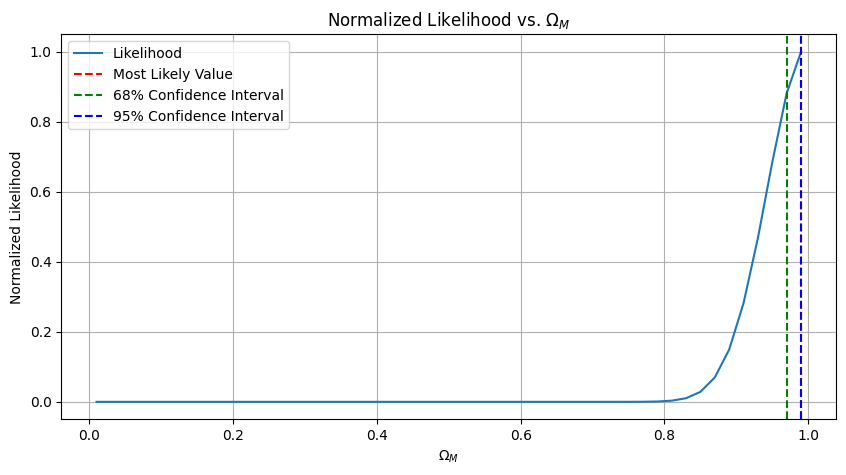

In [162]:
# Fixed values
w = -0.985 # From Union 2.1 paper
Omega_K = 0.0001
k = 0

# Define min and max Omega_M for the range
min_omega_m = 0.01
max_omega_m = 0.99
omega_m_range = np.linspace(min_omega_m, max_omega_m, 50)

# Calculate, normalize likelihoods
likelihoods_m = np.array([log_likelihood(data_cov.values, data, {'Omega_M': omega_m, 'Omega_DE': 1 - omega_m - Omega_K - Omega_R, 'w': w, 'M_n': 25 - 5 * np.log10(70)}, vary_params, k=0) for omega_m in omega_m_range])
likelihoods_m[0] = likelihoods_m[1] # Resolve bug in abnormal dip in likelihood 

likelihoods_m_norm = np.exp(likelihoods_m - np.max(likelihoods_m))

# Fit a polynomial to the normalized likelihood data
coefficients = np.polyfit(omega_m_range, likelihoods_m_norm, 5)
polynomial = np.poly1d(coefficients)

# Sample the polynomial within the omega_m_range
x_fine = np.linspace(min_omega_m, max_omega_m, 1000)
y_fine = polynomial(x_fine)

# Maximum likelihood value
max_x = x_fine[np.argmax(y_fine)]
most_likely_omega_m = omega_m_range[np.argmax(likelihoods_m_norm)]

# Most likely values
print("Most likely Omega_M:", max_x)
print("Most likely Omega_DE:", 1 - max_x)
print("Most likely Omega_M (array max):", most_likely_omega_m)

# Calculate confidence intervals
cumulative_m_likelihood = np.cumsum(likelihoods_m_norm)
cumulative_m_likelihood /= cumulative_m_likelihood[-1]  # Normalize to sum to 1

index_68 = np.where(cumulative_m_likelihood >= 0.68)[0][0]
index_95 = np.where(cumulative_m_likelihood >= 0.95)[0][0]
omega_m_68 = omega_m_range[index_68]
omega_m_95 = omega_m_range[index_95]

# Confidence interval bounds
print("68% confidence interval goes up to:", omega_m_68)
print("95% confidence interval goes up to:", omega_m_95)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(omega_m_range, likelihoods_m_norm, label='Likelihood')
plt.axvline(x=most_likely_omega_m, color='r', linestyle='--', label='Most Likely Value')
plt.axvline(x=omega_m_68, color='g', linestyle='--', label='68% Confidence Interval')
plt.axvline(x=omega_m_95, color='b', linestyle='--', label='95% Confidence Interval')
plt.title('Normalized Likelihood vs. $\\Omega_M$')
plt.xlabel('$\\Omega_M$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()

In [158]:
print("All likelihood values:", likelihoods_m)

All likelihood values: [385.62670594 385.62670594 385.82324413 386.01834346 386.21200821
 386.40424331 386.59504828 386.78442782 386.97238511 387.15892164
 387.34404193 387.52774662 387.71003924 387.89092362 388.07039858
 388.24846839 388.42513716 388.6004044  388.77427327 388.94674621
 389.11782458 389.28751054 389.45580594 389.62271257 389.7882328
 389.95236754 390.11511997 390.2764895  390.43647872 390.59509044
 390.75232624 390.90818444 391.06266851 391.21578062 391.36752118
 391.51789043 391.6668926  391.81452802 391.96079597 392.10569821
 392.24923565 392.3914125  392.53222578 392.67167736 392.80977133
 392.94650426 393.08188039 393.2159002  393.34856293 393.47986985]


In [ ]:
# Fixed values
fixed_omega_m = 0.276 # From Union 2.1 paper
Omega_K = 0.0001
k = 0

# Define min and max w for the range
min_w = -0.25
max_w = 0.25
w_range = np.linspace(min_w, max_w, 50)

# Calculate, normalize likelihoods
likelihoods_w = np.array([log_likelihood(data_cov.values, data, {'Omega_M': fixed_omega_m, 'Omega_DE': 1 - fixed_omega_m - Omega_K - Omega_R, 'w': w_val, 'M_n': 25 - 5 * np.log10(70)}, vary_params, k=0) for w_val in w_range])
likelihoods_w[0] = likelihoods_w[1] # Resolve bug in abnormal dip in likelihood 

likelihoods_w_norm = np.exp(likelihoods_w - np.max(likelihoods_w))

# Fit a polynomial to the normalized likelihood data
coefficients_w = np.polyfit(w_range, likelihoods_w_norm, 5)
polynomial_w = np.poly1d(coefficients_w)

# Sample the polynomial within the omega_m_range
x_fine_w = np.linspace(min_w, max_w, 1000)
y_fine_w = polynomial_w(x_fine_w)

# Maximum likelihood value
max_x_w = x_fine_w[np.argmax(y_fine_w)]
most_likely_w = w_range[np.argmax(likelihoods_w_norm)]

# Most likely values
most_likely_w = w_range[np.argmax(likelihoods_w_norm)]
print("Most likely w:", most_likely_w)

# Calculate confidence intervals
cumulative_likelihood_w = np.cumsum(likelihoods_w_norm)
cumulative_likelihood_w /= cumulative_likelihood_w[-1]

index_68_w = np.where(cumulative_likelihood_w >= 0.68)[0][0]
index_95_w = np.where(cumulative_likelihood_w >= 0.95)[0][0]

w_68 = w_range[index_68_w]
w_95 = w_range[index_95_w]

# Confidence interval values
print("68% confidence interval for w goes up to:", w_68)
print("95% confidence interval for w goes up to:", w_95)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(w_range, likelihoods_w_norm, label='Likelihood')
plt.axvline(x=most_likely_w, color='r', linestyle='--', label='Most Likely Value')
plt.axvline(x=w_68, color='g', linestyle='--', label='68% Confidence Interval')
plt.axvline(x=w_95, color='b', linestyle='--', label='95% Confidence Interval')
plt.title('Normalized Likelihood vs. $w$')
plt.xlabel('$w$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()

In [159]:
print("All likelihood values:", likelihoods_w)

All likelihood values: [398.40349645 398.40349645 398.6171868  398.80785284 398.97688096
 399.12567229 399.25563744 399.36818938 399.46473752 399.54668061
 399.61539965 399.67225058 399.71855657 399.75560037 399.7846164
 399.80678233 399.82321116 399.83494269 399.84293515 399.8480566
 399.85107643 399.85265678 399.853344   399.85356006 399.85359412
 399.85359409 399.85355933 399.85333989 399.85264197 399.85103406
 399.84795291 399.8427091  399.8344925  399.82237747 399.80532788
 399.782202   399.75175709 399.71265415 399.66346223 399.60266272
 399.52865368 399.43975386 399.33420675 399.21018447 399.06579167
 398.89906925 398.70799808 398.49050251 398.24445425 397.96767534]
